In [13]:
# Standard libraries
import pandas as pd
import numpy as np
from scipy import stats
# Visualization
import matplotlib.pyplot as plt
import datetime
import os 

# os.system("pip install wrds") # TODO: Probably put this in utils.py
import wrds
# os.system("pip install pandas-datareader")
import pandas_datareader.data as web

# os.system("pip install seaborn")
import seaborn as sns
pd.set_option('display.max_columns', None)
from sklearn.linear_model import LinearRegression

# Note we don't actually need pandas_datareader. Could import/use YahooFinanceAPI which gives same info

In [2]:
stock_price_aa_records = pd.read_csv("../data/stock_price_aa_records.csv")
display(stock_price_aa_records)

,Company name,Ticker,Date of Breach,Date Became Aware of Breach,Date of Disclosure,Number of Records,Type of Info,Information,Attack,Stock Price (0 months DoD),...,Stock Price (7 months DoD),Stock Price (8 months DoD),Stock Price (9 months DoD),Stock Price (10 months DoD),Stock Price (11 months DoD),Stock Price (12 months DoD),median stock forecast,mean stock forecast,SIC Code,Region
0,HUMANA INC,HUM,10/12/2020 - 12/16/2020,2020-12-22 00:00:00,2021-02-25,NaN,Personal,SSN | Name | DoB | Address | Phone Number | Em...,Unauthorized Access,381.399994,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Finance, Insurance, Real Estate",US Mid Atlantic
1,HERBALIFE NUTRITION LTD.,HLF,2020-10-01 00:00:00,NaN,2021-02-23,NaN,Personal | Other,Name | Phone Number | Address | DOB | Membersh...,Unauthorized Access,45.279999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Wholesale Trade,Foreign
2,"Ultra Clean Holdings, Inc.",UCTT,NaN,NaN,2021-02-23,NaN,Personal,SSN | Driver's License,ND,48.369999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Manufacturing,US West
3,KROGER CO,KR,NaN,2021-01-23 00:00:00,2021-02-19,NaN,Personal,Name | Email | Phone Number | Address | DOB | ...,Unauthorized Access,33.840000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Retail Trade,US Midwest
4,CINTAS CORP,CTAS,9/16/2020 - 9/20/2020,2020-09-20 00:00:00,2021-02-15,NaN,Financial | Personal,Name | Bank Account,Unauthorized Access,345.100006,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Manufacturing,US Midwest
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732,COSTCO WHOLESALE CORP /NEW,COST,6/19/2014 - 7/15/2015,,2015-09-23,815,Financial,Credit Card | Name | Address | Phone Number | ...,ND,142.649994,...,149.919998,142.009995,158.119995,167.470001,167.940002,153.149994,157.5,158.416667,Retail Trade,US West
733,RITE AID CORP,RAD,8/20/2014 - 7/14/2015,2015-08-17 00:00:00,2015-09-22,NaN,Financial,Credit Card | Name | Address | Phone Number | ...,ND,146.600006,...,160.800003,153.199997,154.800003,137.199997,154.600006,162.000000,170.0,170.000000,Retail Trade,US Mid Atlantic
734,CVS HEALTH Corp,CVS,6/19/2014 - 7/14/2015,2015-08-13 00:00:00,2015-09-11,NaN,Financial,Credit Card | Name | Address | Phone Number | ...,ND,100.800003,...,100.769997,106.099998,96.669998,96.839996,97.110001,91.519997,113.5,113.500000,Retail Trade,US New England
735,WEYERHAEUSER CO,WY,May-2014 - 1/29/2015,2015-01-29 00:00:00,2015-03-17,11000000,Personal,Name | DoB | Address | Email | SSN | Other,Phishing,33.680000,...,29.420000,30.139999,30.870001,25.820000,23.770000,29.450001,38.0,38.250000,"Finance, Insurance, Real Estate",US West


In [3]:
# Cleaning and Dummy encoding
stock_price_aa_records['Type of Info'] = stock_price_aa_records['Type of Info'].str.replace(" ", "")
stock_price_aa_records['Attack'] = stock_price_aa_records['Attack'].str.replace("; ", "|")
stock_price_aa_records = pd.concat([stock_price_aa_records.drop('Type of Info', 1), stock_price_aa_records['Type of Info'].str.get_dummies(sep="|").add_suffix(" (Type of Info)")], 1)
stock_price_aa_records = pd.concat([stock_price_aa_records.drop('Attack', 1), stock_price_aa_records['Attack'].str.get_dummies(sep="|").add_suffix(" (Attack)")], 1)
stock_price_aa_records = pd.concat([stock_price_aa_records.drop('SIC Code', 1), stock_price_aa_records['SIC Code'].str.get_dummies(sep="|").add_suffix(" (Industry)")], 1)
stock_price_aa_records = pd.concat([stock_price_aa_records.drop('Region', 1), stock_price_aa_records['Region'].str.get_dummies(sep="|").add_suffix(" (Region)")], 1)

In [4]:
stock_price_aa_records.drop(columns = ['ND (Type of Info)', 'ND (Attack)', 'Mining (Industry)', 'Foreign (Region)'], inplace = True)
display(stock_price_aa_records)

,Company name,Ticker,Date of Breach,Date Became Aware of Breach,Date of Disclosure,Number of Records,Information,Stock Price (0 months DoD),Stock Price (1 months DoD),Stock Price (2 months DoD),...,Services (Industry),Transportation & Public Utilities (Industry),Wholesale Trade (Industry),Canada (Region),US Mid Atlantic (Region),US Midwest (Region),US New England (Region),US Southeast (Region),US Southwest (Region),US West (Region)
0,HUMANA INC,HUM,10/12/2020 - 12/16/2020,2020-12-22 00:00:00,2021-02-25,NaN,SSN | Name | DoB | Address | Phone Number | Em...,381.399994,414.660004,NaN,...,0,0,0,0,1,0,0,0,0,0
1,HERBALIFE NUTRITION LTD.,HLF,2020-10-01 00:00:00,NaN,2021-02-23,NaN,Name | Phone Number | Address | DOB | Membersh...,45.279999,46.299999,NaN,...,0,0,1,0,0,0,0,0,0,0
2,"Ultra Clean Holdings, Inc.",UCTT,NaN,NaN,2021-02-23,NaN,SSN | Driver's License,48.369999,55.090000,NaN,...,0,0,0,0,0,0,0,0,0,1
3,KROGER CO,KR,NaN,2021-01-23 00:00:00,2021-02-19,NaN,Name | Email | Phone Number | Address | DOB | ...,33.840000,34.689999,NaN,...,0,0,0,0,0,1,0,0,0,0
4,CINTAS CORP,CTAS,9/16/2020 - 9/20/2020,2020-09-20 00:00:00,2021-02-15,NaN,Name | Bank Account,345.100006,351.600006,NaN,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732,COSTCO WHOLESALE CORP /NEW,COST,6/19/2014 - 7/15/2015,,2015-09-23,815,Credit Card | Name | Address | Phone Number | ...,142.649994,158.149994,163.449997,...,0,0,0,0,0,0,0,0,0,1
733,RITE AID CORP,RAD,8/20/2014 - 7/14/2015,2015-08-17 00:00:00,2015-09-22,NaN,Credit Card | Name | Address | Phone Number | ...,146.600006,124.400002,154.199997,...,0,0,0,0,1,0,0,0,0,0
734,CVS HEALTH Corp,CVS,6/19/2014 - 7/14/2015,2015-08-13 00:00:00,2015-09-11,NaN,Credit Card | Name | Address | Phone Number | ...,100.800003,102.000000,97.839996,...,0,0,0,0,0,0,1,0,0,0
735,WEYERHAEUSER CO,WY,May-2014 - 1/29/2015,2015-01-29 00:00:00,2015-03-17,11000000,Name | DoB | Address | Email | SSN | Other,33.680000,32.150002,32.340000,...,0,0,0,0,0,0,0,0,0,1


In [15]:
# Important Note
# I think we should predict percent stock price changes instead of actual dollar stock price change. 
# But I could see using the latter if you want to use number of records or stuff like that.
lst = []
months_after = 12 #Toggle this value
col = []
for i in range(0, months_after + 1):
    col.append("Stock Price (%s months DoD)" % i)

In [10]:
stock_prices = pd.DataFrame()
n = 1 
for x in col[1:]:
    stock_prices[n] = stock_price_aa_records.apply(lambda row: (row[x] - row[col[0]])/row[col[0]], axis = 1)
    n += 1

In [11]:
test = stock_price_aa_records.drop(columns=['Company name', 'Ticker', 
                                            'Date of Breach', 'Date Became Aware of Breach', 
                                            'Date of Disclosure', 'Information'])
test.drop(columns=col, inplace = True)
test.drop(columns = ['median stock forecast', 'mean stock forecast'], inplace = True)
table = test
table = pd.concat([test, stock_prices], axis=1, join='inner')
display(table)

,Number of Records,Financial (Type of Info),Intrusion (Type of Info),Other (Type of Info),Personal (Type of Info),Exploit (Attack),Malware (Attack),Misconfiguration (Attack),Phishing (Attack),Ransomware (Attack),...,3,4,5,6,7,8,9,10,11,12
0,NaN,0,0,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,0,0,1,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,0,0,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,0,0,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,1,0,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732,815,1,0,0,0,0,0,0,0,0,...,0.130249,0.077392,0.051945,0.067157,0.050964,-0.004487,0.108447,0.173992,0.177287,0.073607
733,NaN,1,0,0,0,0,0,0,0,0,...,0.073670,0.051842,0.084584,0.090041,0.096862,0.045020,0.055934,-0.064120,0.054570,0.105048
734,NaN,1,0,0,0,0,0,0,0,0,...,-0.060119,-0.058333,-0.076290,-0.014484,-0.000298,0.052579,-0.040972,-0.039286,-0.036607,-0.092064
735,11000000,0,0,0,1,0,0,0,1,0,...,-0.021378,-0.080760,-0.077197,-0.155285,-0.126485,-0.105107,-0.083432,-0.233373,-0.294240,-0.125594


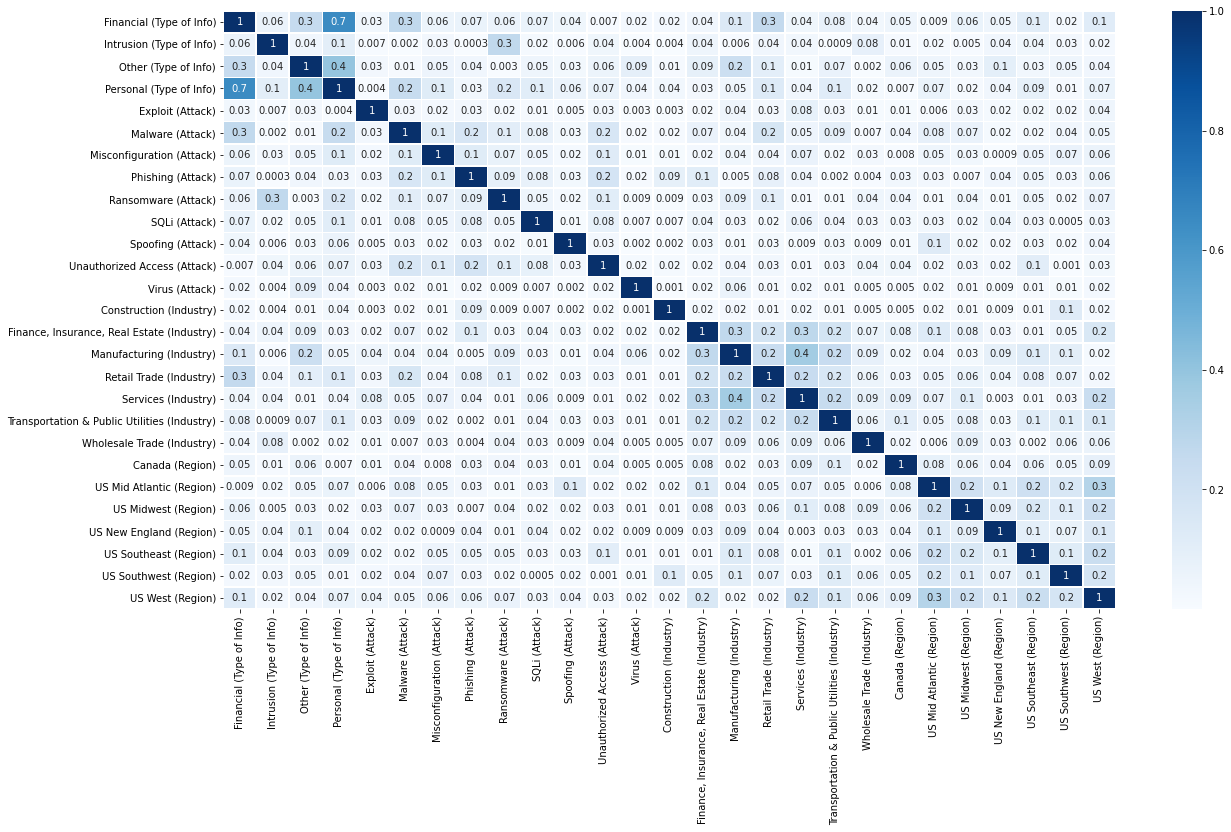

In [14]:
# Correlation matrix using absolute value of correlation
plt.subplots(figsize = (20,11))
corr = test.corr().abs()
sns.heatmap(corr, annot = True, cmap = "Blues", fmt = '.1g', linewidths=.5,)
plt.show()